<a href="https://colab.research.google.com/github/TienLungSun/RL-Unity-ML-Agent/blob/main/8.%20DQN%20to%20learn%20Push%20block%20(3)%20(MLAgent_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mlagents_envs.environment import UnityEnvironment

In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else: 
    device= torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 3060


### DQN 

In [ ]:
N_STATES  = 210  # 105+105
N_ACTIONS = 7  # 1 branch with 7 values, move forward/backward, rotate R/L, move R/L 
N_AGENTS = 3

hidden_units = 256 #from ymal file

LEARNING_RATE = 0.0003
MEMORY_CAPACITY = 500 #10000

In [ ]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(N_STATES, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.out = nn.Linear(hidden_units, N_ACTIONS)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.out(x)

In [ ]:
eval_net = Net().to(device)

In [ ]:
optimizer = torch.optim.Adam(eval_net.parameters(), lr=LEARNING_RATE)
loss_func = nn.MSELoss()

In [ ]:
target_net = Net().to(device)

### interact with Unity to fill the reply buffer

In [ ]:
def Interact_with_Unity_one_step (DecisionSteps):
    s1 = torch.FloatTensor(DecisionSteps.obs[0])
    s2 = torch.FloatTensor(DecisionSteps.obs[1])
    s = torch.cat((s1, s2), 1).to(device)
    action = eval_net(s)
    MaxIdxOfEachAgent = torch.unsqueeze(torch.max(action, 1)[1], 1)
    ActionIdxArray = MaxIdxOfEachAgent.cpu().data.numpy()
    env.set_actions(behaviorName, ActionIdxArray+1) 
    env.step()
    return s, ActionIdxArray

In [ ]:
MEMORY = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))  # (s, a, r, s_) 
print(MEMORY.shape)

(500, 422)


In [ ]:
env = UnityEnvironment(file_name= None, base_port=5004)

In [ ]:
env.reset()
behaviorNames = list(env.behavior_specs.keys())
behaviorName = behaviorNames[0]
print(behaviorName)

PushBlock?team=0


In [ ]:
MemoryIdx = 0
DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
while (MemoryIdx < MEMORY_CAPACITY):
    if(len(DecisionSteps)==0):
        print("Step", MemoryIdx, ": no decision steps, reset!")
        env.reset()
        DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
        continue

    #interacts with Unity one step, but collect data only when all agents
    #have decision steps
    s, ActionIdxArray = Interact_with_Unity_one_step (DecisionSteps)
    
    NextDecisionSteps, NextTerminalSteps = env.get_steps(behaviorName)
    if(len(DecisionSteps) != N_AGENTS or len(NextDecisionSteps) != N_AGENTS): 
        print(MemoryIdx, "not all agents having decision steps", \
              DecisionSteps.agent_id, "next: ", NextDecisionSteps.agent_id)
    else:
        #after one step, if all agents have decision steps then collect data
        #collect reward of this action from next decision and terminal steps
        s1 = torch.FloatTensor(NextDecisionSteps.obs[0])
        s2 = torch.FloatTensor(NextDecisionSteps.obs[1])
        s_ = torch.cat((s1, s2), 1).to(device)
        r = NextDecisionSteps.reward
        for agentIdx in range(N_AGENTS):
            transition = np.hstack((s[agentIdx].cpu().numpy(), ActionIdxArray[agentIdx], r[agentIdx], s_[agentIdx].cpu().numpy()))
            MEMORY[MemoryIdx, :] = transition
            MemoryIdx += 1
            if(MemoryIdx == MEMORY_CAPACITY):
                break
    DecisionSteps, TerminalSteps = NextDecisionSteps, NextTerminalSteps  

###  Start to learn. After each step, take a batch of trining data from memory. After every N steps, update targetNN using evalNN. 

In [ ]:
BATCH_SIZE = 50
GAMMA = 0.9
TARGET_REPLACE_ITER = 20    # target update frequency

In [ ]:
MaxStep = 100

In [ ]:
lossLst = []
step = 1
MemoryIdx = MEMORY_CAPACITY
while (step < MaxStep):
    print(step, end=", ")
    DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
    if(len(DecisionSteps)==0):
        print("Step", MemoryIdx, ": no decision steps, reset!")
        env.reset()
        DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
        continue

    Interact_with_Unity_one_step (DecisionSteps) 
    NextDecisionSteps, NextTerminalSteps = env.get_steps(behaviorName)
    if(len(DecisionSteps) != N_AGENTS or len(NextDecisionSteps) != N_AGENTS): 
        print("Step", step, " not all agents having decision steps", \
          DecisionSteps.agent_id, "next: ", NextDecisionSteps.agent_id)
    else:
        #after one step, if all agents have decision steps then collect data
        #collect reward of this action from next decision and terminal steps
        s1 = torch.FloatTensor(NextDecisionSteps.obs[0])
        s2 = torch.FloatTensor(NextDecisionSteps.obs[1])
        s_ = torch.cat((s1, s2), 1).to(device)
        r = NextDecisionSteps.reward
        for agentIdx in range(N_AGENTS):
            transition = np.hstack((s[agentIdx].cpu().numpy(), ActionIdxArray[agentIdx], r[agentIdx], s_[agentIdx].cpu().numpy()))
            MEMORY[MemoryIdx% MEMORY_CAPACITY, :] = transition
            MemoryIdx += 1

    # target parameter update
    if (step % TARGET_REPLACE_ITER == 0):
        print("Update target Q-network\n")
        target_net.load_state_dict(eval_net.state_dict())

    # take one batch of training data from memory to update evalNN
    sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
    b_memory = MEMORY[sample_index, :]
    b_s = torch.FloatTensor(b_memory[:, :N_STATES]).to(device)
    b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int)).to(device)
    b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2]).to(device)
    b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:]).to(device)
    q_eval = eval_net(b_s).gather(1, b_a)
    q_next = target_net(b_s_).detach()
    q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
    loss = loss_func(q_eval, q_target)
    lossLst.append(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    step = step + 1

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, Update target Q-network

21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, Update target Q-network

41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, Update target Q-network

61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, Update target Q-network

81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [ ]:
env.close()

In [ ]:
import matplotlib.pyplot as plt

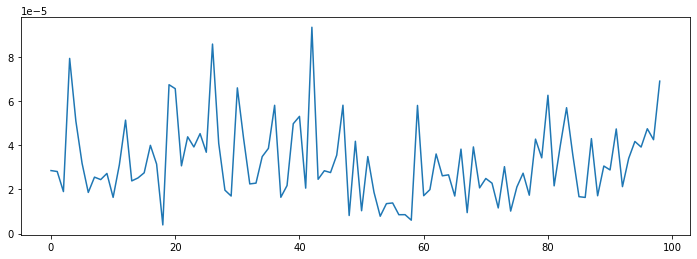

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(lossLst)
plt.show()